# Exploring EPICA Dome C records with Pyleoclim

## Authors

Julien Emile-Geay [![ORCID](https://img.shields.io/badge/ORCID-0000--0001--5920--4751-A6CE39?logo=orcid)](https://orcid.org/0000-0001-5920-4751) and Deborah Khider [![ORCID](https://img.shields.io/badge/ORCID-0000--0001--7501--8430-A6CE39?logo=orcid)](https://orcid.org/0000-0001-7501-8430)

## Preamble

### Goals

In this demo, we use [Pyleoclim](https://medium.com/cyberpaleo/introducing-pyleoclim-paleoclimate-timeseries-analysis-and-visualization-with-python-5b33f384e93) to explore the mystery of Ice Ages as documented from the EPICA Dome C ice core.

Technical skills involved:
- loading data using [pandas](https://pandas.pydata.org)
- applying and interpreting [spectral analysis](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#psd-pyleoclim-psd) in Pyleoclim
- applying and interpreting [singular spectrum analysis](https://en.wikipedia.org/wiki/Singular_spectrum_analysis) in Pyleoclim
- applying and interpreting [Wavelet Transform Coherency](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#coherence-pyleoclim-coherence) analysis

### Data
 
The Deuterium data $\delta D$  was published by [Jouzel et al. (2007)](https://doi.org/10.1126/science.1141038). It is a proxy for the temperature of snow formation above the site, taken to be representative of Antarctic temperature over such timescales. The demo also makes use of $CO_2$ measurements came from [Luthi et al (2008)](https://doi.org/10.1038/nature06949), corrected by [Bereiter et al. (2015)](https://doi.org/10.1002/2014GL061957).


For a video version, check out [this link](https://youtu.be/E75bPv8pwfY), published in Dec 2021 under version 0.7.4.  

### Reading time

15min

### Keywords

Pyleoclim, EPICA Dome C, Spectral Analysis, Singular Spectrum Analysis, Wavelet Transform Coherency

Let us first load necessary packages:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pyleoclim as pyleo
import numpy as np
pyleo.set_style('web')

## Loading and visualizing $\delta D$ series

Let's load the data into a `pandas` DataFrame: 

In [2]:
filepath = '../data/edc3deuttemp2007.csv'
dDdf = pd.read_csv(filepath)
dDdf.head()

,Age,Deuterium,Temperature
0,38.37379,-390.9,0.88
1,46.81203,-385.1,1.84
2,55.05624,-377.8,3.04
3,64.41511,-394.1,0.35
4,73.15077,-398.7,-0.42


Let's have a look at the DataFrame and see if there are any missing values:

In [3]:
dDdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5788 entries, 0 to 5787
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          5788 non-null   float64
 1   Deuterium    5785 non-null   float64
 2   Temperature  5788 non-null   float64
dtypes: float64(3)
memory usage: 135.8 KB


There seems to be missing values in the Deuterium data. This is not an issue to work with Pyleoclim since the first step is to create an object called `Series` (more info [here](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#series-pyleoclim-series)), which will remove any missing values and sort the values in ascending order with default parameters:

In [3]:
dDts = pyleo.Series(time=dDdf['Age']/1000, # This transforms the data into kyr
                    value= dDdf['Deuterium'],
                    time_name='Age',time_unit='kyr BP',
                    value_name = r'$\delta D$',
                    value_unit=u'\u2030',
                    label=r'EPICA Dome C $\delta D$')

NaNs have been detected and dropped.
Time axis values sorted in ascending order


We can plot this with a single line of code, which greatly simplifies life:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [kyr BP]', ylabel='$\\delta D$ [‰]'>)

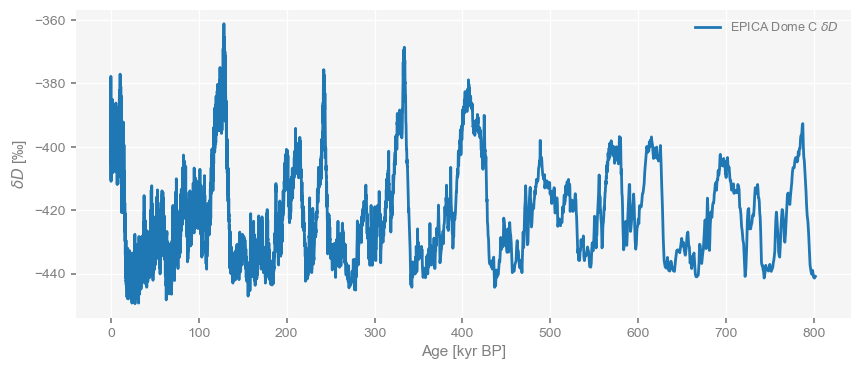

In [5]:
dDts.plot()

Notice how we put in quite a bit of metadata (information about the data) when we created the Series object, and that this information is now being used by the code to properly label axes for you. Structuring and labeling your data is a little more work upfront but it pays big dividends down the line. Let's see that now.

First, take a look at the distribution of time increments: 

Text(0.5, 1.0, 'Distribution of age increments')

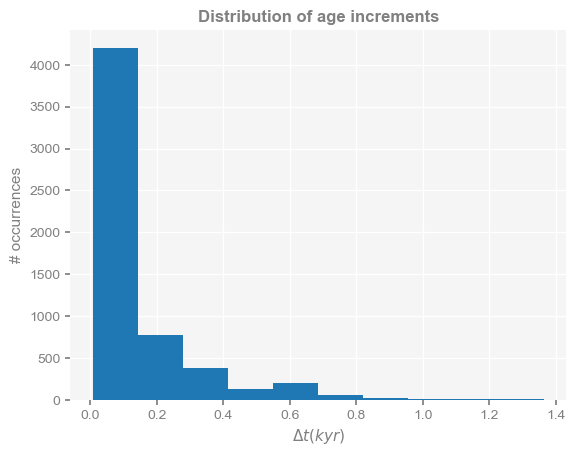

In [12]:
fig, ax = plt.subplots()
plt.hist(np.diff(dDts.time))
plt.xlabel(r'$\Delta t (kyr)$')
plt.ylabel('# occurrences')
plt.title('Distribution of age increments',weight='bold')

The data are not evenly spaced, which is a challenge for spectral analysis because most timeseries analysis methods (e.g. Fourier analysis) make the implicit assumption that data are evenly spaced, so applying those tools to unevenly-spaced data will result in methods not behaving as they are supposed to.

 ## Spectral Analysis
 
 Thankfully, Pyleoclim can deal with that challenge (unevenly-spaced data) very easily. Two of the spectal methods in the package can handle an uneven time axis:
 - Lomb-Scargle periodogram
 - Weighted-Wavelet Z-transform
 
 The former is fast, but far from optimal when interested in looking at the slope of the spectrum. WWZ is usually better, but can be very slow for large datasets.

### Lomb-Scargle Periodogram

We start with the [Lomb-Scargle periodogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html), which may be accessed via the [`spectral` method](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.spectral) associated with any `Series` object:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [kyr]', ylabel='PSD'>)

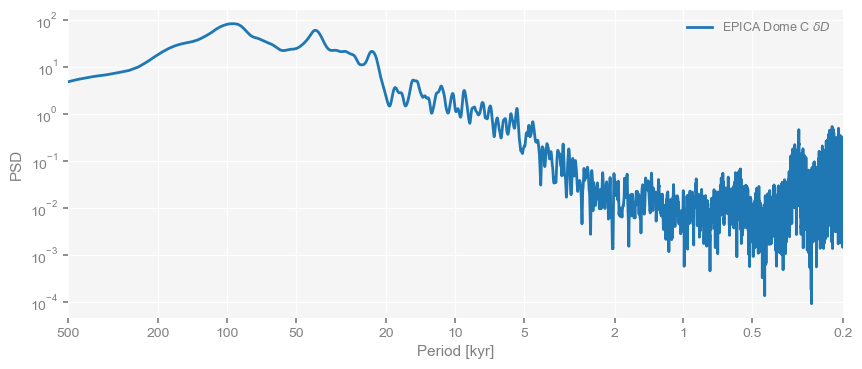

In [4]:
psd_ls = dDts.standardize().spectral(method='lomb_scargle')
psd_ls.plot()

Notice how we chained together two commands to do this: we first standardized the data (not strictly necessary, but useful later) and computed the spectrum. The output (called a periodogram) is stored in a variable (we'll see this is a good idea why in a minute). Then we plotted it. Notice also how the plot contains all the labels you would want, and the frequency axis is labeled in terms of periods, which are much more intuitive than their inverse (periods).  

We could also have chained all three commands to directly create the plot. This can be useful for data exploration; but in this case, the periodogram is not saved as a variable and is therefore not available for later use.

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [kyr]', ylabel='PSD'>)

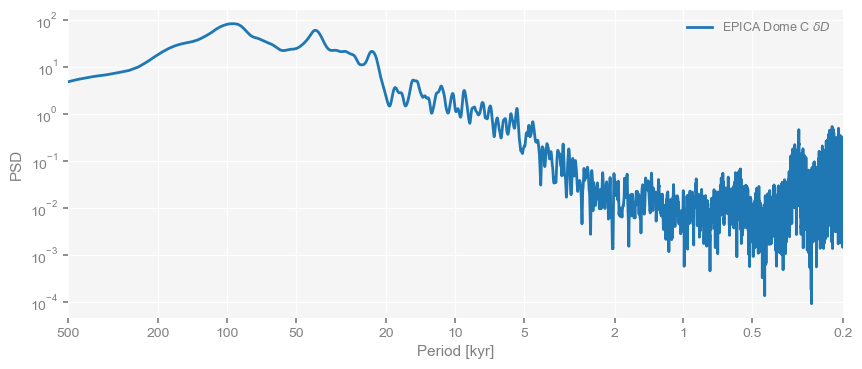

In [5]:
dDts.standardize().spectral(method='lomb_scargle').plot()

Which of these peaks are significant? To do so, the method [`signif_test`](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.psds.PSD.signif_test) can be applied to the [`PSD` object](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#psd-pyleoclim-psd) `psd_ls`, the structure that stored the result from the LS method:

Using serial execution for this method on a Mac platform


Performing spectral analysis on individual series: 100%|██████████| 20/20 [01:32<00:00,  4.65s/it]


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [kyr]', ylabel='PSD'>)

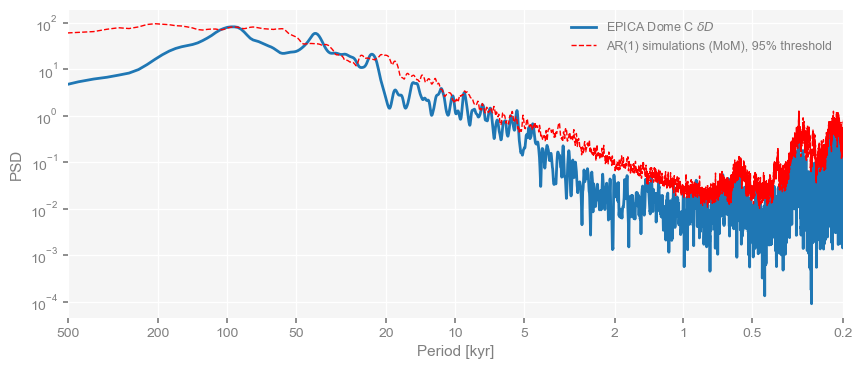

In [9]:
psd_ls_signif = psd_ls.signif_test(number=20) # simulate AR(1) benchmarks
psd_ls_signif.plot()

We see that the orbital periods poke above the 95% threshold, but not by much. Certainly, none of the high-frequency wiggles are. It would make more sense to interpolate the data at 0.5ky resolution and redo this. In fact, you can do this all in a single line of code:

Performing spectral analysis on individual series: 100%|██████████| 200/200 [00:07<00:00, 26.15it/s]


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [kyr]', ylabel='PSD'>)

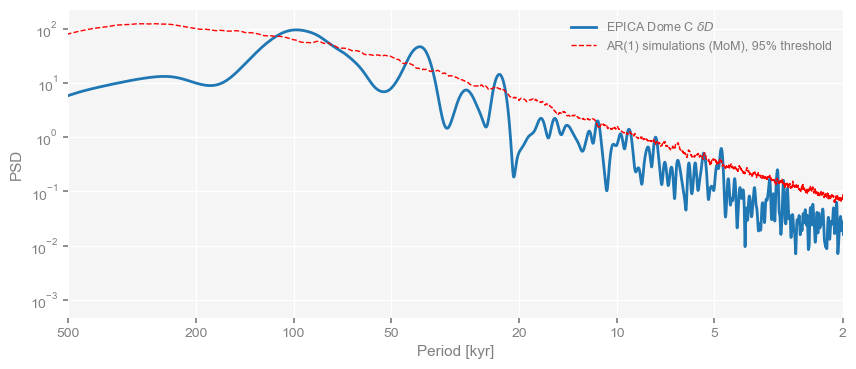

In [16]:
dDts.interp(step=0.5).standardize().spectral(method='lomb_scargle').signif_test(number=200).plot()

The result is still a bit noisy, but at least we've cut all that high-frequency junk, and because the timeseries are shorter, the computations are much faster. We can see peaks poking above the AR(1) significance level at the classical orbital periodicities: 21 ky (precession), 41 ky (obliquity) and 100 ky (eccentricity), with a number of higher frequency peaks breaching that limit as well.  

Now, let's see what the Weighted Wavelet Z-transform (WWZ) makes of the same data:

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [kyr]', ylabel='PSD'>)

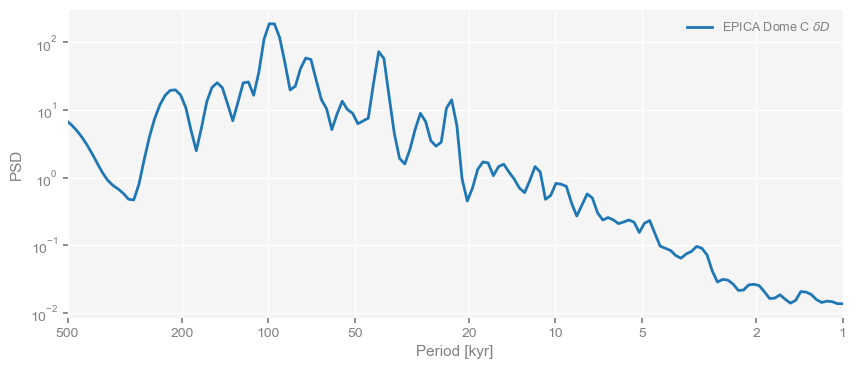

In [17]:
dD05 = dDts.interp(step=0.5).standardize() # save it for future use
psd_wwz = dD05.spectral(method='wwz')
psd_wwz.plot()

Notice how we saved the output of the calculation into a structure called `psd_wwz` before passing that to the plot function; this is to save time, as these calculation can get lengthy. Indeed:

Performing spectral analysis on individual series:   0%|          | 0/50 [00:00<?, ?it/s]OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [kyr]', ylabel='PSD'>)

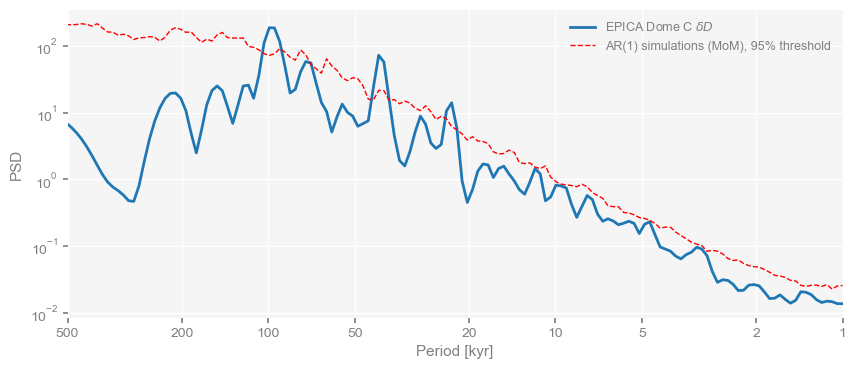

In [18]:
psd_wwz_sig = psd_wwz.signif_test(number=50)
psd_wwz_sig.plot()

The same orbital periods around 20, 40 and 100 kyr pop out, with a few high-frequency bumps grazing the 95% threshold. This may disappear if we ran more AR(1) benchmarks (say, 1000), but running 50 already took some time. You'd certainly want to invest that time for paper/talk, but in this demo we have other fish to fry. 

Let us note in passing that we could plot both of these spectra on the same plot, and add Multitaper Method (MTM) for good measure:

<Axes: xlabel='Period [kyr]', ylabel='PSD'>

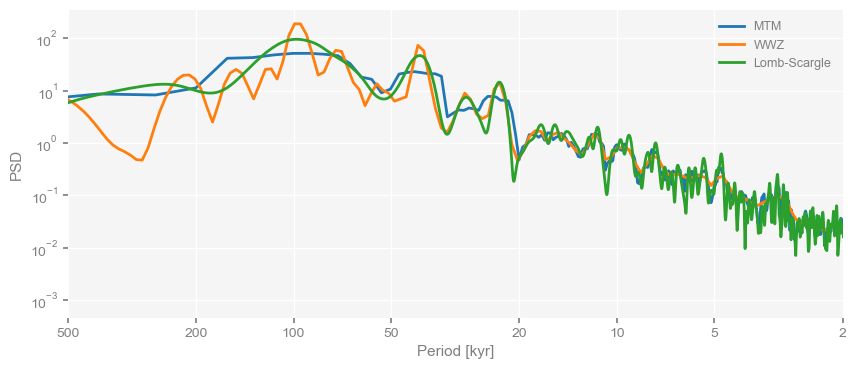

In [19]:
psd_ls  = dD05.spectral(method='lomb_scargle')
psd_mtm = dD05.spectral(method='mtm')
fig, ax = psd_mtm.plot(label='MTM')
psd_wwz.plot(ax=ax,label='WWZ')
psd_ls.plot(ax=ax,label='Lomb-Scargle')



 We see that MTM's bias variance tradeoff (with the default time-bandwith product used here) results in very attenuated, broad peaks at orbital periods. WWZ (again with default parameters) results in sharper peaks, with a secondary one around 80ky. Lomb-Scargle is in between those two extremes, and markedly noisier at high frequencies (no matter what is done to its parameters - try it)

## Singular Spectrum Analysis

If we really wanted to focus on orbital periods, we might want to clean the record still further. One way to do this is to apply [Singular Spectrum Analysis (SSA)](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.ssa) to a standardized, interpolated version of the series (SSA will not work on unevenly spaced data).

In [20]:
dDssa =  dD05.ssa()

The output [`SSARes` object](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.ssares.SsaRes), `dDssa`, contains a bunch of usable information, with some associated methods. The first thing that one does with a decomposition like this is to look at the eigenvalue spectrum via a "scree plot": 

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'SSA scree plot'}, xlabel='Mode index $i$', ylabel='$\\lambda_i$'>)

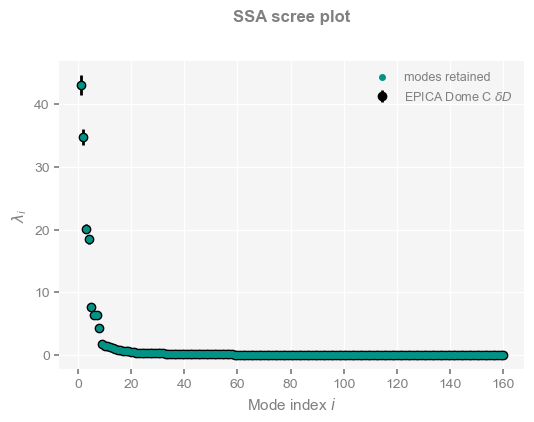

In [21]:
dDssa.screeplot() 

Clearly, the first 8 eigenvalues are a cut above the rest. We should be able to reconstruct most behavior of interest using just those 8. Indeed, if we sum their variance we get to over 99%:

In [22]:
dDssa.pctvar[:7].sum()

85.49401831607675

Let's extract those first 8 modes using `RCmat`, the matrix containing the reconstructed SSA modes, and plot it alongside the original, interpolated data: 

<Axes: xlabel='Age [kyr BP]', ylabel='$\\delta D$ [‰]'>

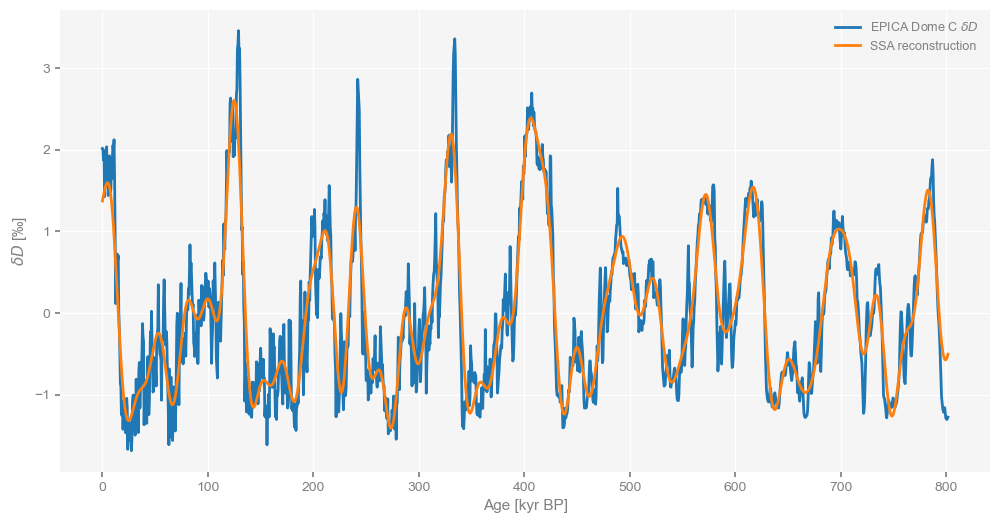

In [23]:
fig, ax = plt.subplots(figsize=(12,6))
dD05.plot(ax=ax)
dDrc = dD05.copy()
dDrc.value = dDssa.RCmat[:,:7].sum(axis=1); dDrc.label = 'SSA reconstruction'
dDrc.plot(ax=ax)

Let's compute its WWZ spectrum and plot it along the old one:

<Axes: xlabel='Period [kyr]', ylabel='PSD'>

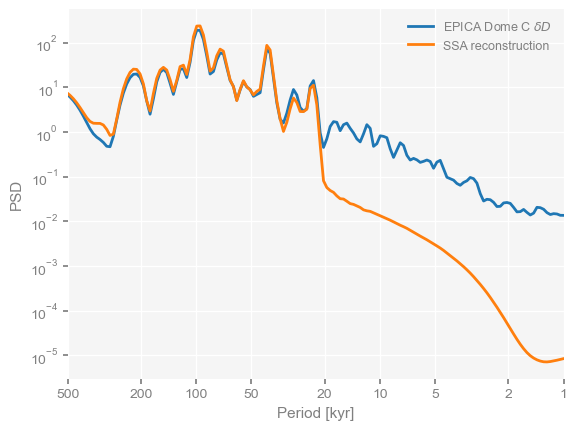

In [24]:
fig, ax = plt.subplots()
psd_wwz.plot(ax=ax)
psd_rcwwz = dDrc.spectral(method='wwz')
psd_rcwwz.plot(ax=ax)

We see that SSA was able to capture the most essential swings of the original series, while filtering out the high frequency noise. In this respect, it acted very much like a lowpass filter, which we could also have applied like so:

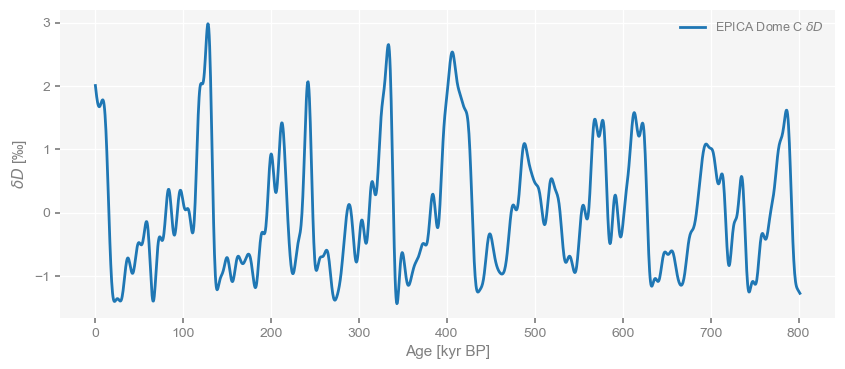

In [25]:
dDlow = dD05.filter(method='lanczos',cutoff_scale=10).plot()

## Wavelet Analysis

Lastly, we play with [wavelet analysis](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.wavelet), which may be used to "unfold" a spectrum and look at its evolution over time.  

In [26]:
scal = dD05.wavelet()

We can now use the [`summary_plot` functionality](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.summary_plot), which stacks together the timeseries itself, its scalogram, and the power spectral density (PSD) obtained from summing the wavelet coefficients over time. By default, the function will calculate the periodogram and scalogram for you. But since we have already done so, we can pass the results of these analyses directly to the plotting function:

(<Figure size 800x1000 with 4 Axes>,
 {'ts': <Axes: xlabel='Age [kyr BP]', ylabel='$\\delta D$ [‰]'>,
  'scal': <Axes: xlabel='Age [kyr BP]', ylabel='Scale [kyrs]'>,
  'psd': <Axes: xlabel='wwz PSD'>,
  'cb': <Axes: xlabel='cwt Amplitude'>})

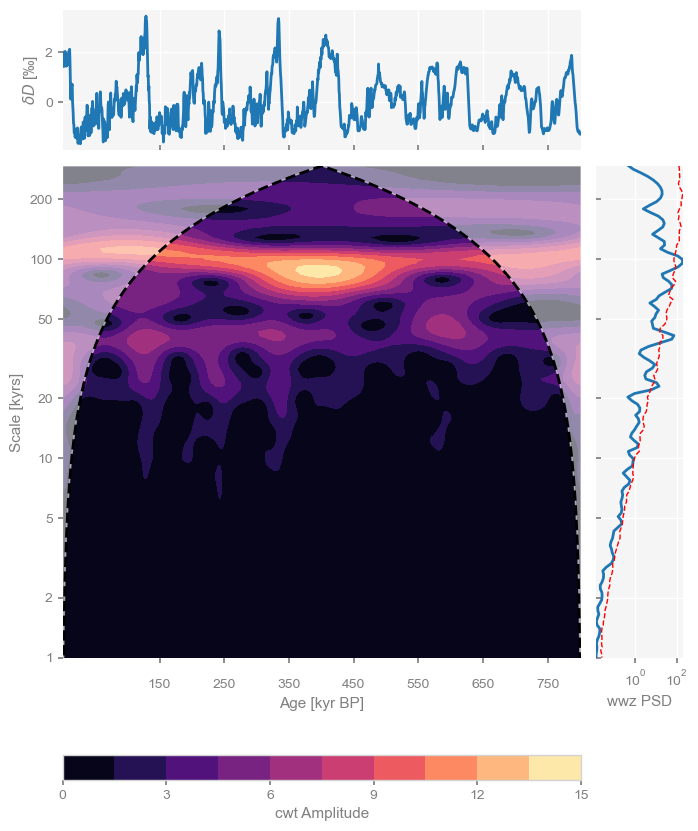

In [27]:
dD05.summary_plot(psd=psd_wwz_sig,scalogram=scal)

The scalogram reveals how spectral power (technically, wavelet power) changes over time. Integrating this wavelet density over time yields something close to the spectral density (PSD), which this summary plot displays to the right of the scalogram. Integrating over scale recovers the original signal, which is plotted on top. However, note that the PSD and scalogram were obtained from different methods here, so they are not exactly comparable as indicated by the labels. For figures intended for publication, make sure that your labels reflect the methods use for transparency. If space of the essence, do so in the caption.  

There is another difference between this PSD and scalogram: the PSD came with an estimate of significance ; the scalogram did not. However, this is easy to add in; we just apply the `signif_test()` method to the scalogram, and pass its result to `summary_plot()`:

(<Figure size 800x1000 with 4 Axes>,
 {'ts': <Axes: xlabel='Age [kyr BP]', ylabel='$\\delta D$ [‰]'>,
  'scal': <Axes: xlabel='Age [kyr BP]', ylabel='Scale [kyrs]'>,
  'psd': <Axes: xlabel='wwz PSD'>,
  'cb': <Axes: xlabel='cwt Amplitude'>})

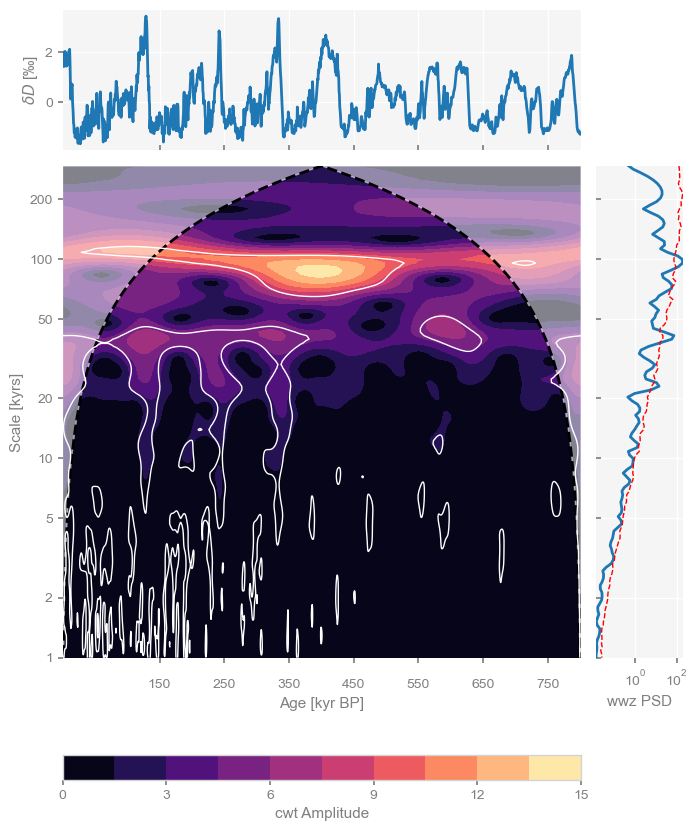

In [28]:
scal_sig = scal.signif_test(method='ar1asym')
dD05.summary_plot(psd=psd_wwz_sig,scalogram=scal_sig)

The white lines delineate regions of the scalogram that are significant against an AR(1) benchmark, so encircle "islands" of notable power. We see that the 100kyr periodicity is particularly pronounced around 300-600 kyr BP, while the 40 and 20kyr periodicities are more pronounced in the later portions (since 400 ky BP). This may be because of the compaction of the ice at depth, which you wouldn't know from analyzing just this dataset. Paleoclimate timeseries must always be interpreted with those possible artifacts in mind. 

Now, notice that we specified the method 'ar1asym' for the asssessment of significance; this tells the code to use an asymptotic approximation to the distribution of the AR(1) benchmarks, making it lightning-fast. We could also have used direct simulation (the default method, because it applies to other wavelet methods like `wwz`), and indeed this would yield a very similar result: 

Performing wavelet analysis on individual series: 100%|██████████| 200/200 [00:05<00:00, 38.87it/s] 


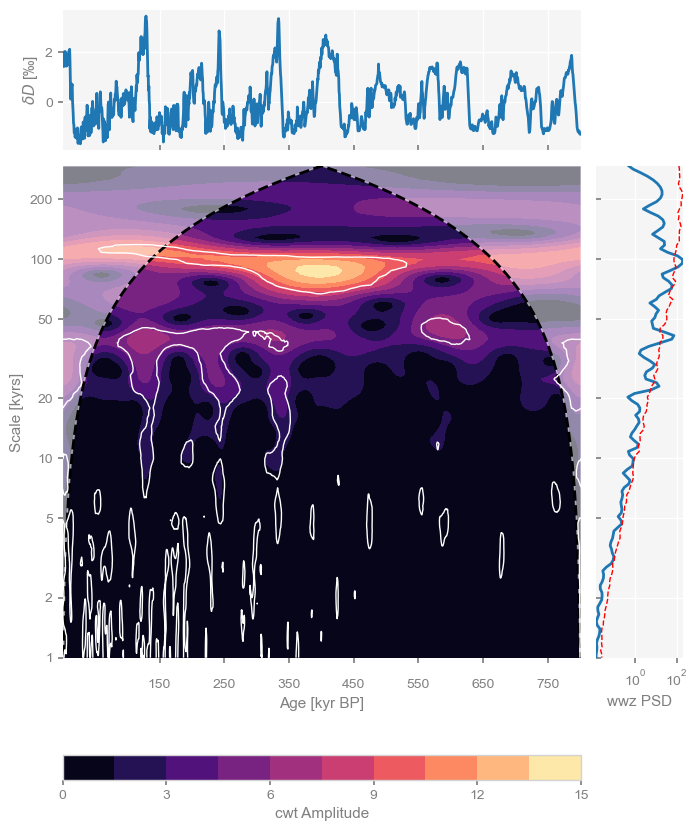

In [29]:
scal_sig = scal.signif_test(number=200)
fig, ax_d = dD05.summary_plot(psd=psd_wwz_sig,scalogram=scal_sig);

## Assessing Memory

One may also assess the scaling properties of a timeseries with `Pyleoclim`. Scaling exponents are a very useful way to characterize timeseries, and are related to the concept of "memory". One method of doing so, is to fit a regression line to the PSD and estimate its slope, indicative of fundamental scaling laws in the continuum of climate variability. Pyleoclim makes this easy:

(<Figure size 800x400 with 1 Axes>,
 <Axes: xlabel='Period [kyr]', ylabel='PSD'>)

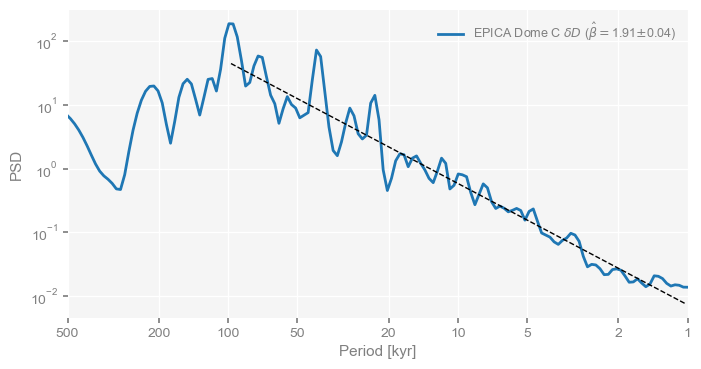

In [30]:
psd_fit = psd_wwz.beta_est(fmin=1/100,fmax=1)
psd_fit.plot(figsize=[8, 4])

Note that this slope is related to the Hurst exponent: $H = \frac{\beta-1}{2}$

In [31]:
beta = psd_fit.beta_est_res['beta'] # extra the scaling exponent
Hurst = (beta-1)/2   # convert to a Hurst exponent
print("The series has a Hurst parameter of " + '{:4.4f}'.format(Hurst))

The series has a Hurst parameter of 0.4544


This value is close to 0.5, the expected value for a Brownian motion type of stochastic process. 

## Temperature and $CO_2$

Now let us load the $CO_2$ composite from this and other neighboring sites around Antarctica:

In [32]:
url = 'ftp://ftp.ncdc.noaa.gov/pub/data/paleo/icecore/antarctica/antarctica2015co2composite.txt'
co2df = pd.read_csv(url,skiprows=137,sep='\t')
co2df.head()

,age_gas_calBP,co2_ppm,co2_1s_ppm
0,-51.03,368.02,0.06
1,-48.00,361.78,0.37
2,-46.28,359.65,0.10
3,-44.41,357.11,0.16
4,-43.08,353.95,0.04


In [33]:
co2ts = pyleo.Series(time=co2df['age_gas_calBP']/1000,value= co2df['co2_ppm'],time_name='Age',time_unit='kyr BP',value_name = r'$CO_2$',value_unit='ppm',label='EPICA Dome C CO2')

Time axis values sorted in ascending order


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [kyr BP]', ylabel='$CO_2$ [ppm]'>)

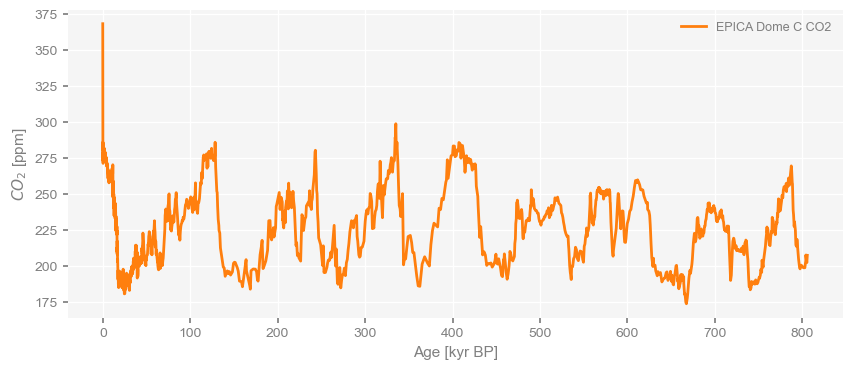

In [34]:
co2ts.plot(color='C1')

We see very similar Ice Ages as in the deuterium data and of course a precipitous rise since the Industrial Revolution.  To plot the two series side by side, we can put them into a [`MultipleSeries` object](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#multipleseries-pyleoclim-multipleseries) and use the default plot function:

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Age [ka]', ylabel='value'>)

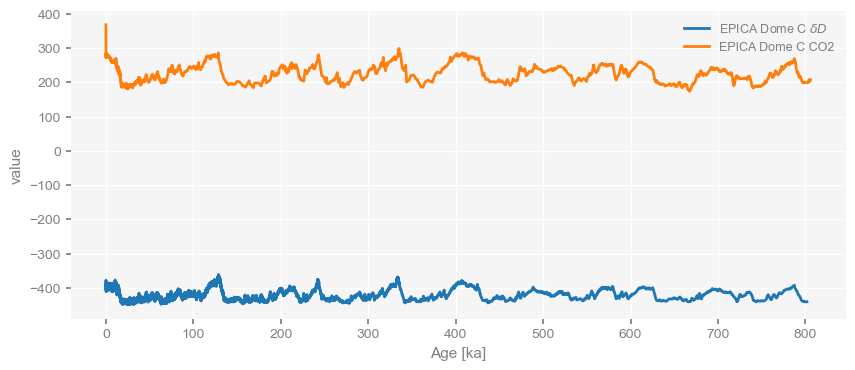

In [35]:
ms = pyleo.MultipleSeries([dDts,co2ts])
ms.plot()

By default, the MultipleSeries class assumes commensurate units, which is not really the case here. Fear not, we can just standardize the series:

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Age [ka]', ylabel='value'>)

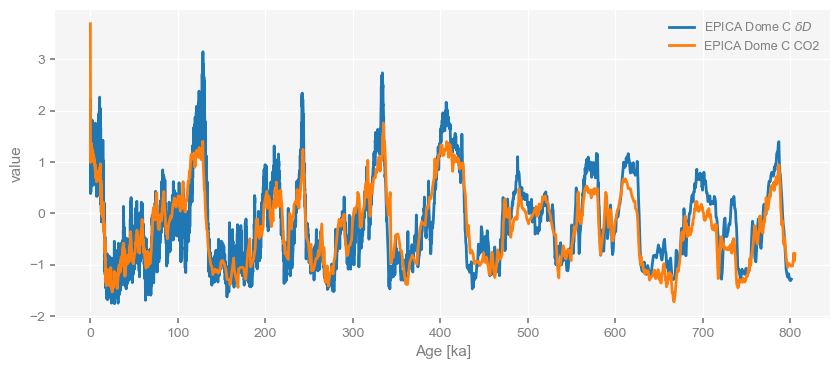

In [36]:
ms.standardize().plot()

We could also plot them as a [stack](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.multipleseries.MultipleSeries.stackplot), like so:

(<Figure size 640x480 with 3 Axes>,
 {0: <Axes: ylabel='$\\delta D$ [‰]'>,
  1: <Axes: ylabel='$CO_2$ [ppm]'>,
  'x_axis': <Axes: xlabel='Age [ka]'>})

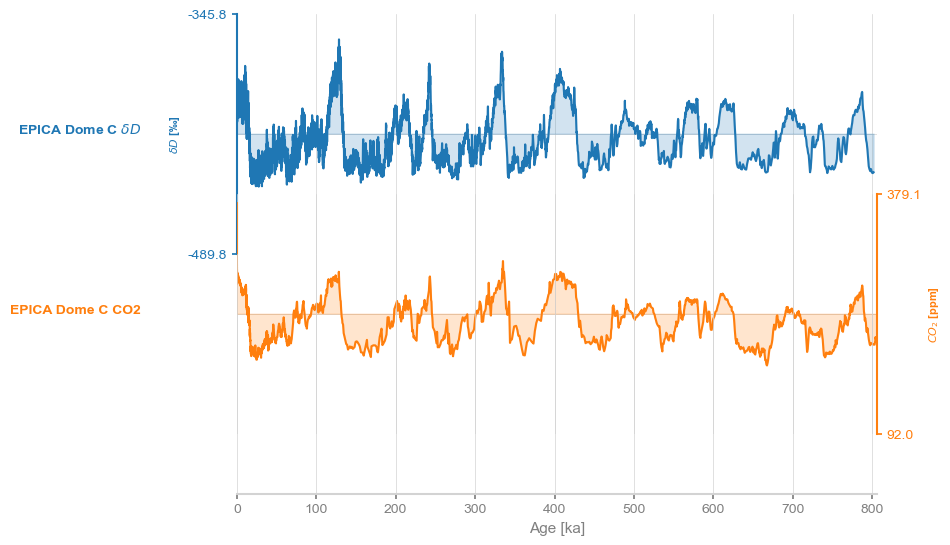

In [37]:
ms.stackplot()

Now, one might be interested in lead/lag relationships between those two series. Before that, a brief primer: the temperature proxy $\delta D$ is measured on the ice, whereas $CO_2$ is measured in the air trapped in the ice. Because bubbles close only progressively as the firn gets compacted, the air can be younger than the surrounding ice by several hundred years. The ice core community has worked diligently on this for decades and have made very clever adjustments to correct for this effect, but that is to be kept in mind when comparing those two data streams. 

With that in mind, let us apply [wavelet transform coherency](https://hal.archives-ouvertes.fr/hal-00302394/) to identify phase relationships between the two series at various scales. The [`wavelet_coherence` method](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.wavelet_coherence) is attached to the `Series` object in Pyleoclim and takes as input another `Series` object:

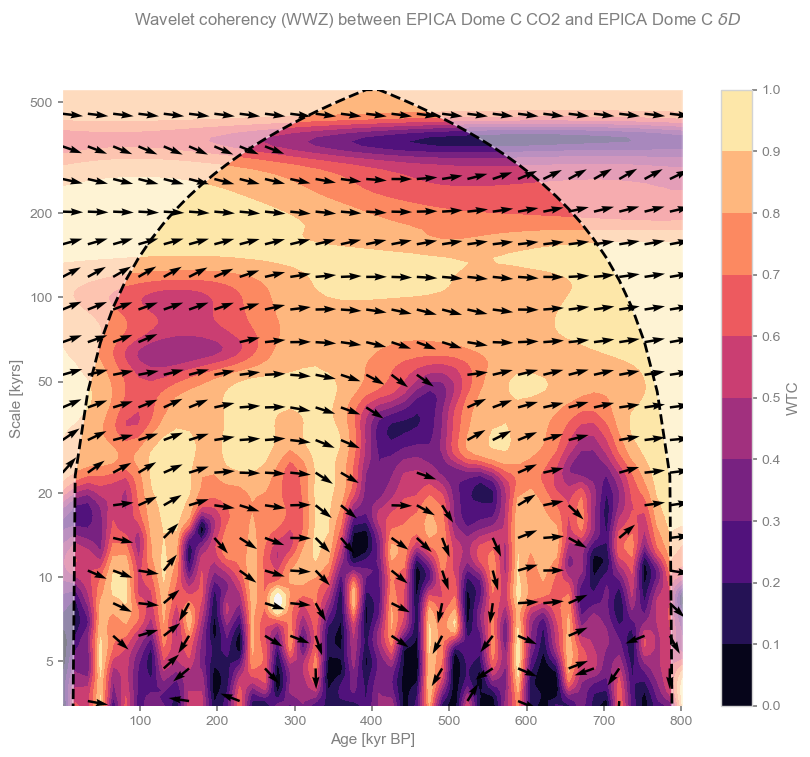

In [38]:
coh = co2ts.wavelet_coherence(dDts,method='wwz')
fig, ax = coh.plot()

Arrows pointing to the right indicate a phase angle close to zero at all scales longer than precession. We can quantify that by computing the average phase angle in a given range of scales, like so:

In [39]:
coh.phase_stats(scales=[80,100])

Results(mean_angle=0.11337289763284723, kappa=22.001092896028084, sigma=0.21570904255129503, kappa_hi=367.46235077157496, sigma_lo=0.052202294161905125)

This means that on orbital timescales, the two series are essentially in phase ; there is no _consistent_ lead or lag between the two series. This is remarkable given the dating challenges mentioned earlier, and is widely interpreted to mean that on such timescales, atmospheric $CO_2$ is a part of a positive feedback loop amplifying orbitally-triggered changes in temperature. However, the variance of this angle is fairly high, and by this test it does not register as a very consistent signal.
Lastly, note that in the modern era, atmospheric $CO_2$ is of course a forcing (the largest climate forcing, currently), acting on much, much faster timescales for which the climate system is still catching up. You would not know it from this analysis, but it's important to state out loud, given that climate deniers have an annoying tendency to cherry-pick the paleoclimate record in support of their feeble arguments. 

One might be tempted to interpret phase angles at shorter scales. Let us first see if they are significant against AR(1) benchmarks, As before this can be done in one function call, though some patience is required to obtain the result. 

<div style="
    padding: 10px; 
    background-color: #fff3cd; 
    border-left: 6px solid #ffcc00; 
    margin: 10px 0;">
    <strong>Warning:</strong> This cell may take more than 2 minutes to run
</div>

In [40]:
coh_sig = coh.signif_test(number=100)

Performing wavelet coherence on surrogate pairs:   0%|          | 0/100 [00:00<?, ?it/s]OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine 

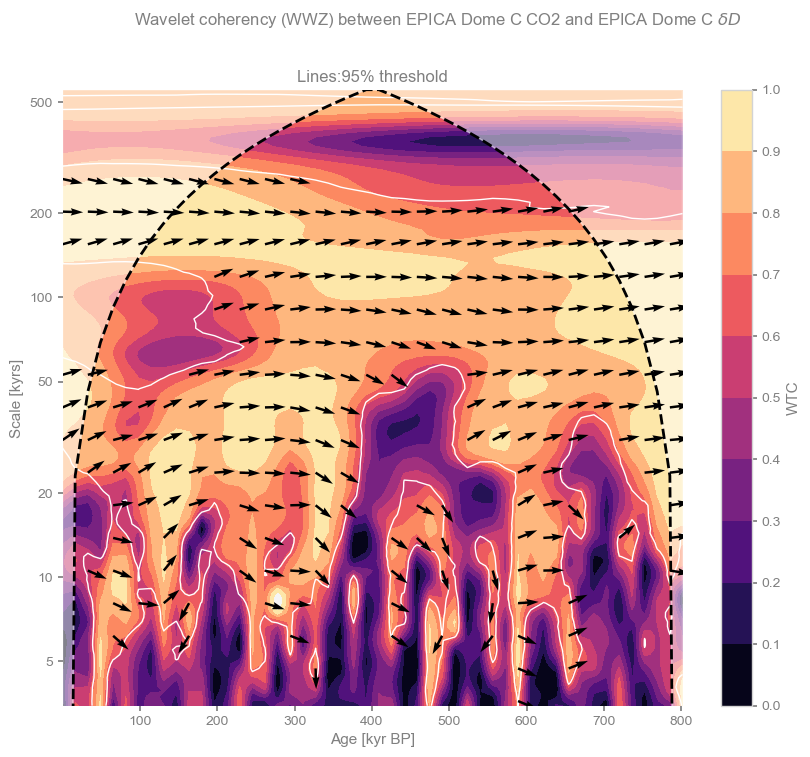

In [41]:
fig, ax = coh_sig.plot()

These phase differences are indeed significant according to this test, but mostly inconsistent (at a given scale, the arrows veer one way or the other). This would not be a good candidates for identifying a robust lead or lag. One would find the same result with `phase_stats()`. 

Another consideration is that coherency is like the correlation coefficient in wavelet space: it tells you how similar two series are for a given time and scale, yet it says nothing about what fraction of the total variability is shared. This is better measured by the cross-wavelet transform (XWT), which highlights areas of high common power. Both of those, along with the original series, can be visualized with one swift function call:

(<Figure size 900x1200 with 6 Axes>,
 {'ts1': <Axes: ylabel='$CO_2$ [ppm]'>,
  'ts2': <Axes: xlabel='Age [kyr BP]', ylabel='$\\delta D$ [‰]'>,
  'wtc': <Axes: ylabel='Scale [kyrs]'>,
  'xwt': <Axes: xlabel='Age [kyr BP]', ylabel='Scale [kyrs]'>})

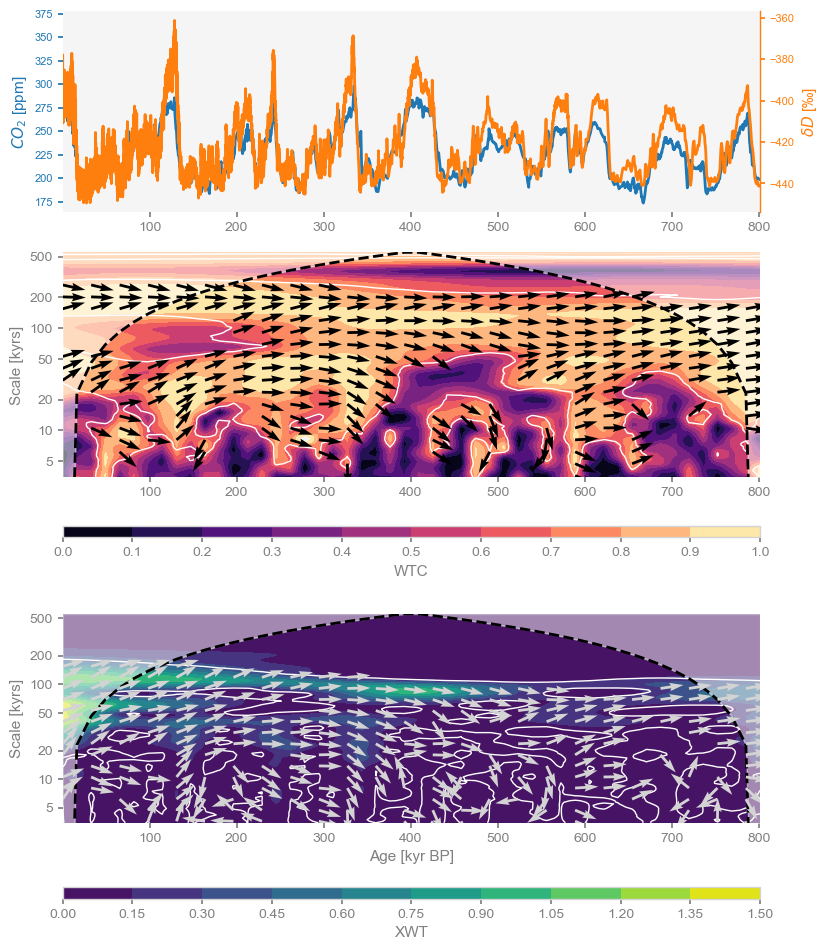

In [42]:
coh_sig.dashboard()

Here we see that the orbital bands are the only ones to show up consistently throughout the record, but precession and obliquity fade before 200 ky BP in their common power, and the XWT band near 120 ka drifts to 80ka back in time. This means that, out of the large swathes of WTC one would consider "coherent", only those areas highlighted in XWT in green-yellow are likely important.  That's where we stop the banter, though: time to go ask a glaciologist about what is going on in those datasets. I know a few good ones. 

This concludes our mini tour of paleoclimate timeseries wizardry with Pyleoclim. Be sure to check our [documentation](xhttps://pyleoclim-util.readthedocs.io/en/latest/) for more, and remember that magic tricks are not science until backed up by knowledge. 

Finally, please watch the [PaleoBooks Gallery](https://linked.earth/PaleoBooks/index.html) for more examples. Feel free to get in touch on [Discourse](https://discourse.linked.earth) if you want to suggest (or make!) other demos/tutorials.